## 0. Libraries and Personal Tools

In [1]:
import sys

from os.path import abspath
from yaml import safe_load

from pandas import read_feather, read_csv
from gc import collect
from sklearn.model_selection import GroupShuffleSplit

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set the default figure size and theme to display good looking matplotlib plots.
rcParams["figure.figsize"] = (10, 6)
plt.style.use("fivethirtyeight")

In [3]:
# add absolute path from root to sys.path to use custom modules
sys.path.insert(0, abspath('..'))

In [4]:
from src.features.build_features import *
from src.utils import *

In [5]:
model_config = safe_load(open("../models/config.yaml", "r"))
model_config

{'paths': {'dtypes': './data/raw/test_dtypes.csv',
  'data': './data/interim/sample_10perc_train_compressed.ftr'},
 'data': {'index': ['game_num', 'event_id', 'event_time'],
  'goal_post1': [0.0, -100.0, 6.8],
  'goal_post2': [0.0, 100.0, 6.8]},
 'model': {'team': 'A',
  'type': 'xgb',
  'params': {'objective': 'binary', 'metric': 'neg_log_loss'}}}

## 1. Get Train Data

In [6]:
df = read_feather("../" + model_config["paths"]["data"])
df.set_index(model_config["data"]["index"], inplace=True)

## 2. Get Features and Targets

In [7]:
model_features = read_csv("../" + model_config["paths"]["dtypes"])
FEATURES = [feature for feature in model_features.column.tolist() if feature != "id"]

TEAM = model_config["model"]["team"]
TARGET = f"team_{TEAM}_scoring_within_10sec"

## 3. Pipeline Building

In [8]:
# Kudos to: https://towardsdatascience.com/pipeline-columntransformer-and-featureunion-explained-f5491f815f
# Kudos to: https://towardsdatascience.com/4-scikit-learn-tools-every-data-scientist-should-use-4ee942958d9e

from multiprocessing import cpu_count

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler

### 5.1. Player Pipelines

In [9]:
player_position_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", MinMaxScaler()),
        ]
)

player_velocity_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", MaxAbsScaler()),
        ]
)

player_speed_pipe = Pipeline(
    steps=[
        ("speed", PlayerSpeed()),
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ]
)

In [10]:
player_transformations = ColumnTransformer(
    transformers=[
        ("player_demolished", PlayerDemolished(), selector("p[0-5]")),
        ("player_velocity_pipe",  player_velocity_pipe, selector("p[0-5]_vel_")),
        ("player_speed", player_speed_pipe, selector(pattern="p[0-5]_vel_")),
        ("player_position", player_position_pipe, selector("p[0-5]_pos_")),
        ],
    )


### 5.2. Ball Pipelines

In [11]:
ball_velocity_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", MaxAbsScaler()),
        ]
)

ball_speed_pipe = Pipeline(
    steps=[
        ("speed", BallSpeed()),
        ("scaler", StandardScaler()),
        ]
)

ball_position_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", MinMaxScaler()),
        ]
)

distance_ball_goal_posts_pipe = Pipeline(
    steps=[
        ("distance", DistanceBallGoalPosts(posts=[model_config["data"]["goal_post1"], model_config["data"]["goal_post2"]])),
        ("scaler", MinMaxScaler()),
        ]
)

In [12]:
ball_transformations = ColumnTransformer(
    transformers=[
        ("ball_velocity", ball_velocity_pipe, selector("ball_vel_")),
        ("ball_speed", ball_speed_pipe, selector("ball_vel_")),
        ("ball_position", ball_position_pipe, selector("ball_pos_")),
        ("distance_ball_goal_posts", distance_ball_goal_posts_pipe, selector("ball_pos_")),
        ],
    )


### 5.3. Booster Pipelines

In [13]:
booster_timer_pipe = Pipeline(
    steps=[
        ("timer", FunctionTransformer(lambda x: abs(x), feature_names_out="one-to-one")),
        ("scaler", MaxAbsScaler()),
        ]
)

player_boosters_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", MaxAbsScaler()),
        ]
)
        

In [14]:
booster_transformations = ColumnTransformer(
    transformers=[
        ("booster_timer", booster_timer_pipe, selector(pattern="boost[0-5]_timer")),
        ("player_boosters", player_boosters_pipe, selector(pattern="p[0-5]_boost")),
        ],
    )

### 5.4. Team Pipelines

In [15]:
team_centroid_pipe = Pipeline(
    steps=[
        ("team_centroid", TeamCentroid()),
        ("scaler", StandardScaler()),
        ]
)

In [16]:
team_transformations = ColumnTransformer(
    transformers=[
        ("team_centroid", team_centroid_pipe, selector("p[0-5]_pos_")),
        ],
    )   

### 5.5. Main Pipeline

In [17]:
preprocessor = FeatureUnion(
    transformer_list=[
        ("player_transformations", player_transformations),
        ("ball_transformations", ball_transformations),
        ("booster_transformations", booster_transformations),
        ("team_transformations", team_transformations),
        ],
    )

## 4. Dimensionality Reduction (PCA Fine-tuning)

### 4.1. Split Data

In [18]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.model_selection import GridSearchCV, GroupKFold
from xgboost import XGBClassifier

In [19]:
base_model = XGBClassifier(objective='binary:logistic')


In [20]:
main_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("variance_threshold", VarianceThreshold()),
        ("dim_reducer", "passthrough"),
        ("model", base_model),
        ]
    )

In [21]:
from sklearn.model_selection import GroupShuffleSplit

gsp = GroupShuffleSplit(n_splits=2, test_size=0.9, random_state=777)
train_index, test_index = next(gsp.split(df, groups=df.index.get_level_values("game_num")))

X_train = df[FEATURES].iloc[train_index]
y_train = df[TARGET].iloc[train_index]

X_test = df[FEATURES].iloc[test_index]
y_test = df[TARGET].iloc[test_index]

In [22]:
del df

### 4.2. Define Parameter Grid

In [27]:
ROUND_TO = 3
ipca_batch = round(len(X_train) / 50, -ROUND_TO)
min_ipca_batch = int(ipca_batch*0.5)
max_ipca_batch = int(ipca_batch*1.5) + 1
jumps_ipca = int(ipca_batch*0.25)

print(f"ipca_batch: {ipca_batch}")

ipca_batch: 4000.0


In [28]:
param_grid = [
    {
        "dim_reducer": [PCA(svd_solver = 'full')],
        "dim_reducer__n_components": [0.80, 0.85, 0.90, 0.95],

    },
    {
        "dim_reducer": [PCA(svd_solver = 'auto', random_state=777)],
        "dim_reducer__n_components": [26, 28, 30, 32, 34],

    },
    {
        "dim_reducer": [IncrementalPCA()],
        "dim_reducer__n_components": [20, 30, 40, 50],
        "dim_reducer__batch_size": list(range(min_ipca_batch, max_ipca_batch, jumps_ipca)),
    },
]

reducer_labels = ["Full_PCA", "Auto_PCA", "IncrementalPCA"]

### 4.3. Define K-Group-Folds

In [29]:
n_folds = 5

game_num = X_train.index.get_level_values("game_num")
groups = create_kf_groups(game_num, n_folds=n_folds)

gkf = GroupKFold(n_splits=n_folds)

In [30]:
groups.value_counts()

a    44448
b    41855
c    39658
d    38528
e    47456
dtype: int64

### 4.4. Run Grid Search

In [31]:
pca_grid_search = GridSearchCV(
    estimator=main_pipe, 
    param_grid=param_grid, 
    n_jobs=cpu_count(), 
    verbose=2, 
    scoring="neg_log_loss",
    cv=GroupKFold(n_splits=n_folds).split(X_train, y_train, groups=groups),
    )

In [32]:
collect()

551

In [33]:
# %env JOBLIB_TEMP_FOLDER=/home/ian/Desktop/tmp
pca_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 29 candidates, totalling 145 fits
[CV] END dim_reducer=PCA(svd_solver='full'), dim_reducer__n_components=0.8; total time= 3.5min
[CV] END dim_reducer=PCA(svd_solver='full'), dim_reducer__n_components=0.8; total time= 3.6min
[CV] END dim_reducer=PCA(svd_solver='full'), dim_reducer__n_components=0.8; total time= 3.6min
[CV] END dim_reducer=PCA(svd_solver='full'), dim_reducer__n_components=0.8; total time= 3.8min
[CV] END dim_reducer=PCA(svd_solver='full'), dim_reducer__n_components=0.8; total time= 3.6min
[CV] END dim_reducer=PCA(svd_solver='full'), dim_reducer__n_components=0.85; total time= 4.3min
[CV] END dim_reducer=PCA(svd_solver='full'), dim_reducer__n_components=0.85; total time= 4.6min
[CV] END dim_reducer=PCA(svd_solver='full'), dim_reducer__n_components=0.85; total time= 4.7min
[CV] END dim_reducer=PCA(svd_solver='full'), dim_reducer__n_components=0.85; total time= 4.8min
[CV] END dim_reducer=PCA(svd_solver='full'), dim_reducer__n_components=0.85; to

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f60889d79e0>,
             estimator=Pipeline(steps=[('preprocessor',
                                        FeatureUnion(transformer_list=[('player_transformations',
                                                                        ColumnTransformer(transformers=[('player_demolished',
                                                                                                         PlayerDemolished(),
                                                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f60e153ad30>),
                                                                                                        ('player_velocity_pipe',
                                                                                                         Pipelin...
             param_grid=[{'dim_reducer': [PCA(svd_solver='full')],
                          'dim_reducer__n_components': [0.8, 0.85, 0.9, 0.95]},
                         {'dim_reducer': [PCA(random_state=777)],
                          'dim_reducer__n_components': [26, 28, 30, 32, 34]},
                         {'dim_reducer': [IncrementalPCA(batch_size=2000,
                                                         n_components=50)],
                          'dim_reducer__batch_size': [2000, 3000, 4000, 5000,
                                                      6000],
                          'dim_reducer__n_components': [20, 30, 40, 50]}],
             scoring='neg_log_loss', verbose=2)

### 4.5. Best PCA Configuration

In [34]:
pca_grid_search.best_params_

{'dim_reducer': IncrementalPCA(batch_size=2000, n_components=50),
 'dim_reducer__batch_size': 2000,
 'dim_reducer__n_components': 50}

In [35]:
pca_grid_search.best_score_

-0.21905130988841132

In [37]:
var = pca_grid_search.best_estimator_["dim_reducer"].explained_variance_ratio_
var_explained = var.cumsum()

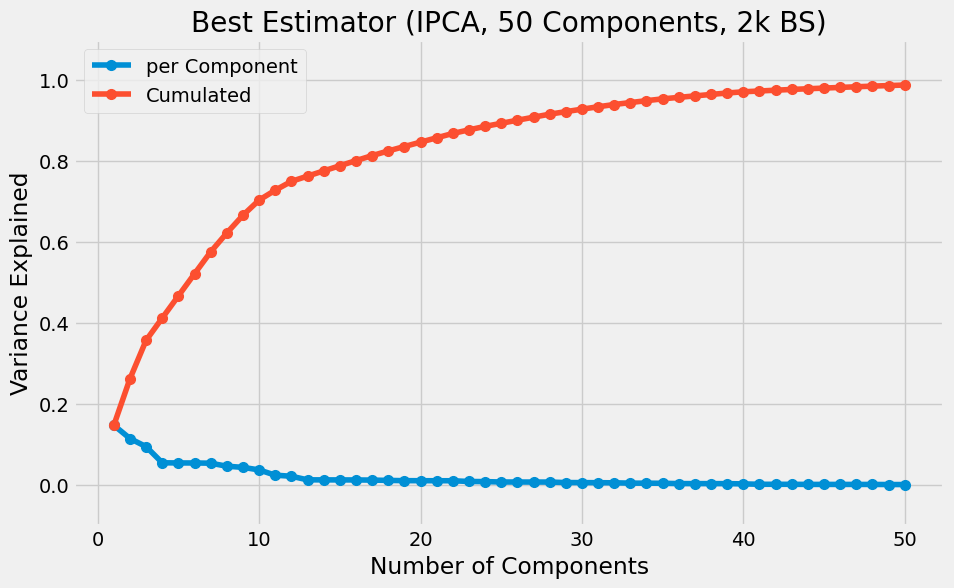

In [99]:
plt.figure()

plt.plot(range(1, len(var_explained)+1), var, label="per Component", marker="o", markersize=7)
plt.plot(range(1, len(var_explained)+1), var_explained, label="Cumulated", marker="o", markersize=7)

plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.ylim(-0.1, 1.1)

plt.title("Best Estimator (IPCA, 50 Components, 2k BS)")
plt.legend()
plt.show()

### 4.6. Rest of PCA Configs (Full PCA)

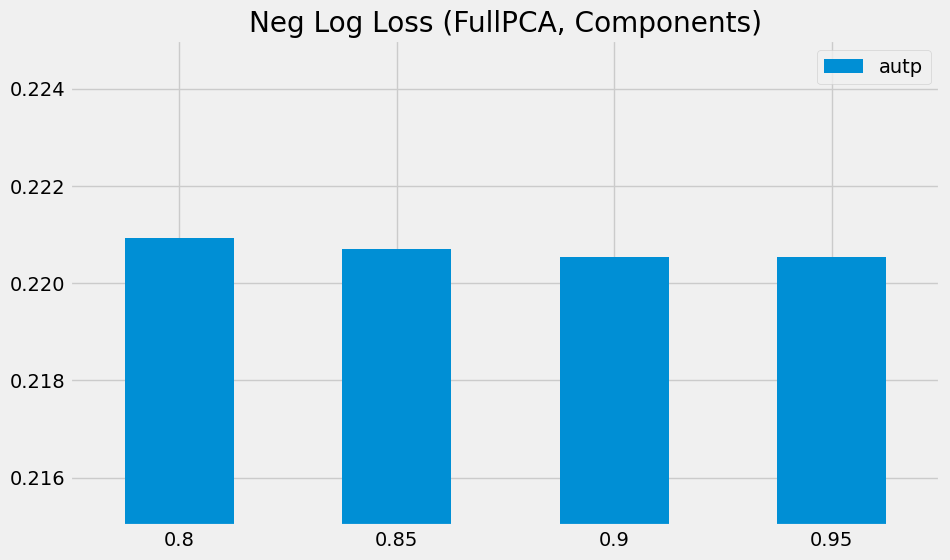

In [129]:
(
    DataFrame(
        data=pca_grid_search.cv_results_["mean_test_score"][:4].reshape(4, 1),
        index=[0.80, 0.85, 0.90, 0.95],
        columns=["full"],
        )
    .abs()
    .plot.bar(rot=0, ylim=(0.215, 0.225), title="Neg Log Loss (FullPCA, Components)")
);

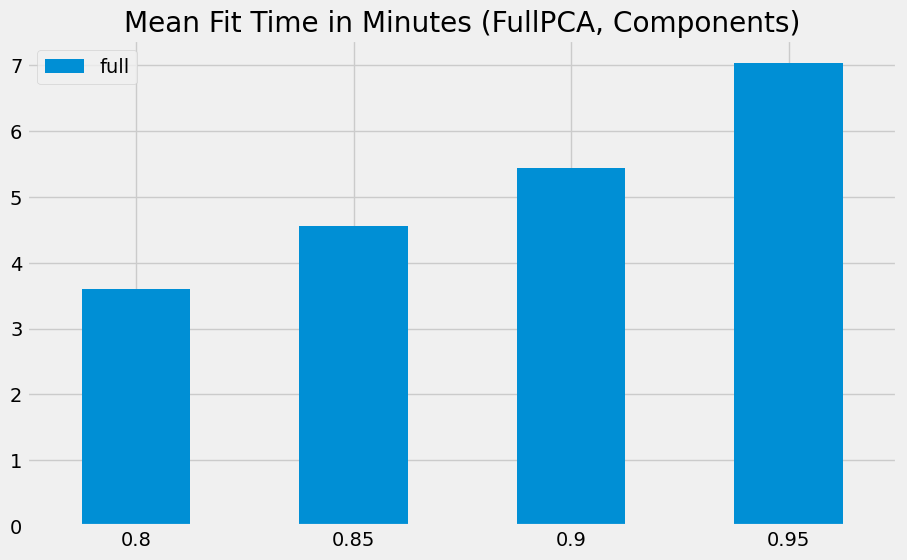

In [131]:
(
    DataFrame(
        data=pca_grid_search.cv_results_["mean_fit_time"][:4].reshape(4, 1),
        index=[0.80, 0.85, 0.90, 0.95],
        columns=["full"],
        )
    .div(60)
    .plot.bar(rot=0, title="Mean Fit Time in Minutes (FullPCA, Components)")
);

### 4.6. Rest of PCA Configs (Auto PCA)

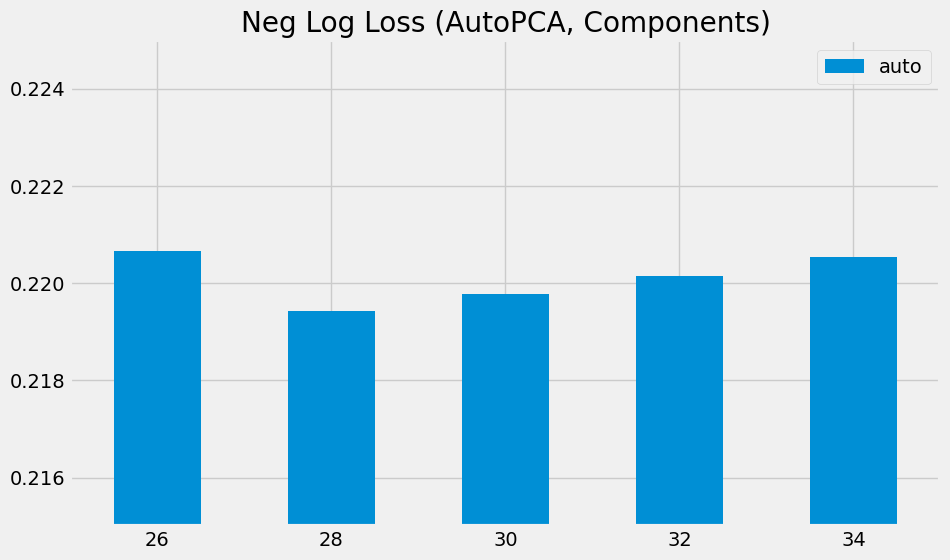

In [130]:
(
    DataFrame(
        data=pca_grid_search.cv_results_["mean_test_score"][5:10].reshape(5, 1),
        index=[26, 28, 30, 32, 34],
        columns=["auto"],
        )
    .abs()
    .plot.bar(rot=0, ylim=(0.215, 0.225), title="Neg Log Loss (AutoPCA, Components)")
);

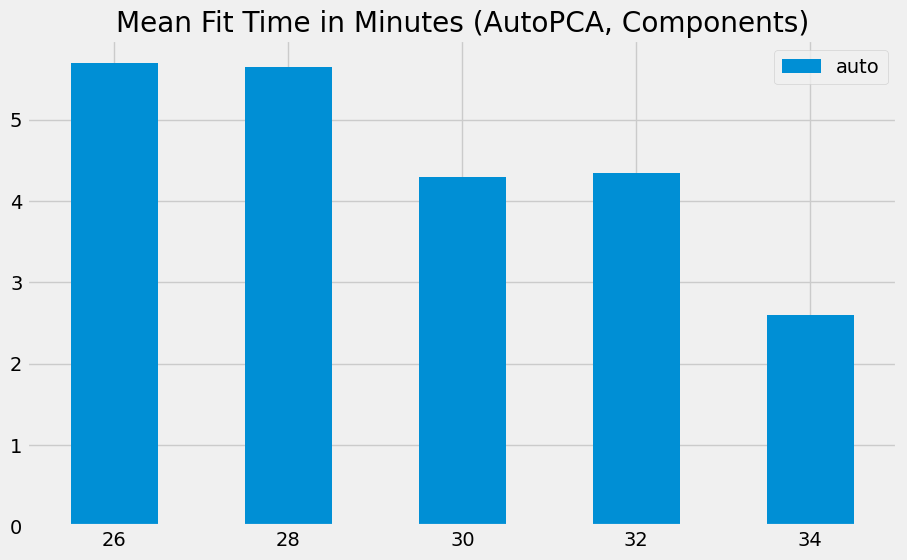

In [128]:
(
    DataFrame(
        data=pca_grid_search.cv_results_["mean_fit_time"][5:10].reshape(5, 1),
        index=[26, 28, 30, 32, 34],
        columns=["auto"],
        )
    .div(60)
    .plot.bar(rot=0, title="Mean Fit Time in Minutes (AutoPCA, Components)")
);

### 4.6. Rest of PCA Configs (Incremental PCA)

In [ ]:
(
    DataFrame(
        data=pca_grid_search.cv_results_["mean_test_score"][5:10].reshape(5, 1),
        index=[26, 28, 30, 32, 34],
        columns=["full"],
        )
    .abs()
    .plot.bar(rot=0, ylim=(0.215, 0.225), title="Neg Log Loss (AutoPCA, Components)")
);

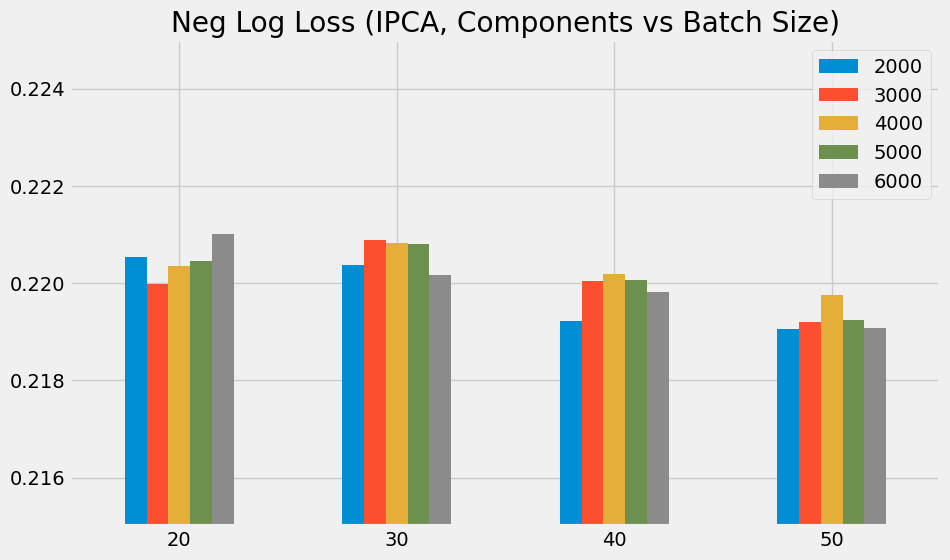

In [108]:
(
    DataFrame(
        data=pca_grid_search.cv_results_["mean_test_score"][-20:].reshape(5, 4), 
        index=list(range(min_ipca_batch, max_ipca_batch, jumps_ipca)),
        columns=[20, 30, 40, 50],
        )
    .transpose().abs()
    .plot.bar(rot=0, ylim=(0.215, 0.225), title="Neg Log Loss (IPCA, Components vs Batch Size)")
);

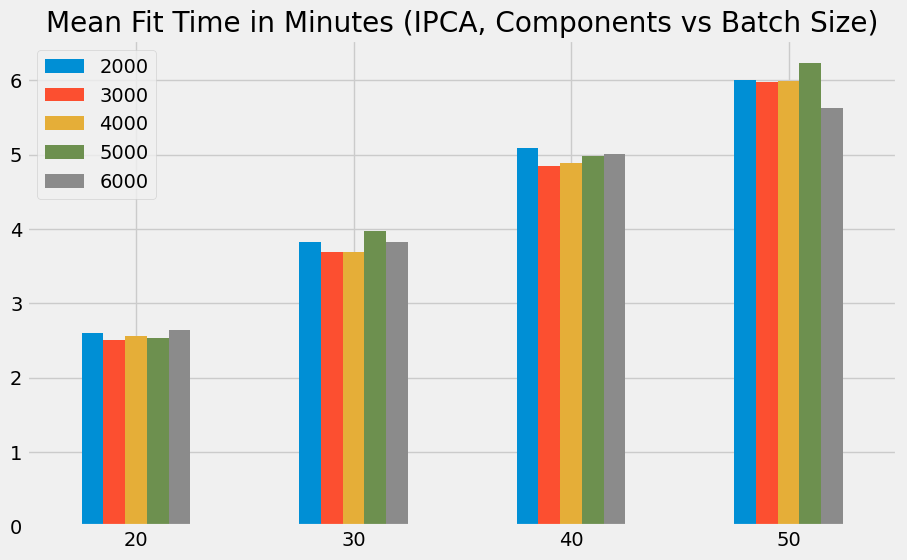

In [95]:
(
    DataFrame(
        data=pca_grid_search.cv_results_["mean_fit_time"][-20:].reshape(5, 4), 
        index=list(range(min_ipca_batch, max_ipca_batch, jumps_ipca)),
        columns=[20, 30, 40, 50],
        )
    .transpose().div(60)
    .plot.bar(rot=0, title="Mean Fit Time in Minutes (IPCA, Components vs Batch Size)")
);